In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
from astropy.table import Table 
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time, TimeDeltaSec

import glowing_waffles.differential_photometry as gwdf

## This should be any one of the images in your table

In [2]:
ccd = CCDData.read('kelt-16-S001-R001-C100-r.fit')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
apass, apass_x, apass_y, apass_for_transform, in_apass_x, in_apass_y = gwdf.find_apass_stars(ccd)
vsx, vsx_x, vsx_y, vsx_names = gwdf.find_known_variables(ccd)

apass_all_coords = SkyCoord(apass['RAJ2000'], apass['DEJ2000'], unit='deg')
apass_for_transform_coords = SkyCoord(apass_for_transform['RAJ2000'], apass_for_transform['DEJ2000'], unit='deg')

C:\Anaconda3\envs\ast366\lib\site-packages\astropy\table\column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


## Change the file name below to match the one your magnitudes are in

In [4]:
input_mags = Table.read('calibrated_magnitudes_kelt_16_faint_13.fits')

## Get our "star_id" for Kelt-16

In [5]:
kelt16_coords = SkyCoord.from_name('kelt-16')

input_coords = SkyCoord(input_mags['RA'], input_mags['Dec'])
idx, d2d, d3d = kelt16_coords.match_to_catalog_sky(input_coords)

kelt_id = input_mags['star_id'][idx]
kelt_id

802

In [6]:
input_mags['mag_cal'] = np.zeros(len(input_mags))
input_mags['zero_point'] = np.zeros(len(input_mags))
input_mags['color_term'] = np.zeros(len(input_mags))
input_mags['t_start_tdb'] = np.zeros(len(input_mags))
input_mags['t_mid_tdb'] = np.zeros(len(input_mags))

mags_grouped = input_mags.group_by('file')

In [7]:
feder = EarthLocation("263.54672d", "46.86678d")

In [8]:
for idx, our_mags in enumerate(mags_grouped.groups):
    print(idx)
    new_mags, matches, transform = gwdf.transform_magnitudes(our_mags, apass, apass_for_transform, 
                                                faintest_mag_for_transform=13,
                                                input_mag_colum='mag_inst_r',
                                                catalog_mag_column='r_mag',
                                                catalog_color_column='B-V'
                                               )
    our_mags['mag_cal'][matches] = new_mags.data.filled(np.nan)
    our_mags['mag_cal'][~matches] = np.nan
    our_mags['zero_point'] = transform.parameters[0]
    our_mags['color_term'] = transform.parameters[1]
    t_utc = Time(our_mags['date-obs'], scale='utc', location=feder)
    our_coords = SkyCoord(our_mags['RA'], our_mags['Dec'])
    delta_t_tdb = t_utc.light_travel_time(our_coords)
    t_tdb = t_utc.tdb + delta_t_tdb
    t_tdb_mid = t_tdb + our_mags['exposure'] / 2
    our_mags['t_start_tdb'][:] = t_tdb.jd
    our_mags['t_mid_tdb'][:] = t_tdb_mid.jd

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


In [9]:
mags_grouped[mags_grouped['star_id'] == 813]

id,xcenter,ycenter,aperture_sum,annulus_sum,RA,Dec,sky_per_pix_avg,sky_per_pix_med,sky_per_pix_std,aperture,aperture_area,annulus_inner,annulus_outer,annulus_area,exposure,date-obs,night,aperture_net_flux,mag_inst_r,airmass,filter,file,star_id,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb,vsx_name,mag_error
,pix,pix,adu,,deg,deg,adu,adu,adu,pix,,pix,pix,,s,,,adu,,,,,,,,,,,,adu
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,int32,float64,float64,float64,bytes1,bytes28,int32,float64,float64,float64,float64,float64,bytes50,float64
781,1787.948845056098,2058.150237692041,20808.57221698761,121391.86424392462,314.2147445679225,31.656110247210144,32.26209999996634,31.9692325592041,9.08347604498193,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,6213.542022692223,-5.456263310539181,1.121,r,kelt-16-S001-R001-C001-r.fit,813,15.05631881193547,20.524021782107393,-0.022386809287169795,2458323.7264892617,2458323.726836484,,0.030919110943438567
784,1785.938622456044,2059.316144539606,20858.7404088974,119886.584471941,314.2148507716824,31.656105195711376,31.59096561546277,31.26988983154297,9.053706194473842,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:21:26,58322,6567.3242572796335,-5.516386360458807,1.119,r,kelt-16-S001-R001-C002-r.fit,813,15.005234437800425,20.53078419934884,-0.017932292930569062,2458323.727565684,2458323.727912906,,0.029255632919843334
784,1784.9537896367412,2060.239942443822,21061.263086795807,120885.11024236679,314.21478100810253,31.6560875312381,32.19647718973571,31.614980697631836,9.213407786951601,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:22:57,58322,6495.919952448519,-5.504516872328452,1.116,r,kelt-16-S001-R001-C003-r.fit,813,15.01128793813637,20.526286396213315,-0.020511909950228484,2458323.728618961,2458323.7289661835,,0.02964272349927733
784,1783.1993768753148,2061.4069123946338,20873.835624694824,121417.08053278923,314.2147811389474,31.656040493470496,32.61946269674147,32.11604309082031,9.489787568159514,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:24:30,58322,6117.1383551082035,-5.439285969201987,1.114,r,kelt-16-S001-R001-C004-r.fit,813,15.080823197245817,20.530155649465307,-0.019660436888239836,2458323.729695388,2458323.7300426103,,0.03143177253830521
785,1781.9027919620642,2062.327054731321,21005.655146598816,120592.66210007668,314.214782618286,31.656011348308038,32.36319065343766,31.94162654876709,9.438249448743965,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:26:02,58322,6364.892618085367,-5.482392913616714,1.112,r,kelt-16-S001-R001-C005-r.fit,813,15.033770061252127,20.525782352422304,-0.01882461414139766,2458323.7307602395,2458323.7311074617,,0.030240423898910528
785,1781.8996289049244,2063.213519686476,20566.57011795044,118674.8752913475,314.2147977308057,31.656118462713398,31.46723964718453,31.064083099365234,9.305156870437177,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:27:34,58322,6331.126275724846,-5.4766176501815975,1.109,r,kelt-16-S001-R001-C006-r.fit,813,15.040195374230713,20.527967277448095,-0.021828284615877658,2458323.73182508,2458323.732172302,,0.030263093600696123
786,1781.9960678450905,2064.1817343334387,20088.65239715576,118884.719876647,314.21486049807714,31.656116236978438,31.41591850157064,31.083864212036133,9.020285637033622,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:29:05,58322,5876.425694231124,-5.395698333386536,1.107,r,kelt-16-S001-R001-C007-r.fit,813,15.120952998078382,20.526803112606675,-0.019866499297297162,2458323.7328783534,2458323.7332255756,,0.032459084644107856
786,1780.9012803195455,2065.175090603007,20302.57527732849,118600.19006443024,314.21478413365315,31.656117568027526,31.640581857604882,31.033759117126465,9.35914577622116,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:30:

In [10]:
mags_grouped.sort('t_start_tdb')

In [11]:
mags_grouped

id,xcenter,ycenter,aperture_sum,annulus_sum,RA,Dec,sky_per_pix_avg,sky_per_pix_med,sky_per_pix_std,aperture,aperture_area,annulus_inner,annulus_outer,annulus_area,exposure,date-obs,night,aperture_net_flux,mag_inst_r,airmass,filter,file,star_id,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb,vsx_name,mag_error
,pix,pix,adu,,deg,deg,adu,adu,adu,pix,,pix,pix,,s,,,adu,,,,,,,,,,,,adu
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,int32,float64,float64,float64,bytes1,bytes28,int32,float64,float64,float64,float64,float64,bytes50,float64
1422,4011.091526838012,3969.142916177813,19740.155430793762,103860.89329612255,314.5432670134417,32.01973136240193,31.808280954476942,31.461752891540527,10.803624996914255,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,5350.428135927457,-5.293886548969706,1.121,r,kelt-16-S001-R001-C001-r.fit,1479,15.214845041740617,20.524021782107393,-0.022386809287169795,2458323.726455484,2458323.7268027063,,0.03554203721814884
1431,3863.942898239571,3998.9143066290862,33952.74383163452,102687.83718004823,314.51558576760186,32.01961637265539,31.504446114354263,31.2497501373291,10.520896497204099,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,19700.46818020352,-6.709106579064407,1.121,r,kelt-16-S001-R001-C001-r.fit,1489,13.799244435989024,20.524021782107393,-0.022386809287169795,2458323.7264559236,2458323.726803146,,0.010865317328612463
1411,3963.0904975394483,3951.90486856516,15249.548798561096,104428.82190561295,314.5352479090502,32.015567615887285,31.808294335373855,31.52717399597168,10.731908677068274,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,859.8154503196401,-3.3089283230064974,1.121,r,kelt-16-S001-R001-C001-r.fit,1468,nan,20.524021782107393,-0.022386809287169795,2458323.7264559385,2458323.7268031607,,0.21162200178674756
1421,3923.008965618607,3969.8875728993826,20822.206637382507,101420.80074810982,314.52733781030184,32.017048316638714,31.151097199642955,30.903825759887695,10.454439681919503,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,6729.782269015484,-5.542917744838749,1.121,r,kelt-16-S001-R001-C001-r.fit,1478,14.962746853484397,20.524021782107393,-0.022386809287169795,2458323.726455944,2458323.7268031663,,0.028532498737706097
1405,4015.1792324262733,3923.173770284605,30234.403473317623,104178.87234064937,314.54572817533784,32.01282162890551,31.792475467154404,31.450231552124023,10.459912367244256,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,15851.826412462999,-6.473113480632851,1.121,r,kelt-16-S001-R001-C001-r.fit,1461,14.035685270542295,20.524021782107393,-0.022386809287169795,2458323.726455993,2458323.726803215,,0.013127131925856725
1417,3848.017315598605,3961.9101672544393,16185.751720428467,115460.04435215145,314.5140998526454,32.013443881563674,31.558219960992364,30.922298431396484,10.712969735233127,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,1909.1493538937557,-4.175014973009543,1.121,r,kelt-16-S001-R001-C001-r.fit,1474,nan,20.524021782107393,-0.022386809287169795,2458323.7264564354,2458323.7268036576,,0.09620434270592455
1419,3723.004118947109,3968.894287448843,16342.364827394485,102438.52531147748,314.49127182053485,32.01053792907989,31.50461414878146,31.270769119262695,10.508239826067275,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,2090.013158979509,-4.273287762138963,1.121,r,kelt-16-S001-R001-C001-r.fit,1476,nan,20.524021782107393,-0.022386809287169795,2458323.7264570193,2458323.7268042415,,0.08801476817405915
1438,3604.9472263665893,4021.055869255223,16588.801261663437,99055.38167959452,314.4680014835236,32.014766868890604,30.492322640378536,30.28482151031494,9.544357245216066,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,

## Identify known variables in the field 

### First, the list of variables...

In [12]:
vsx

_q,OID,n_OID,Name,V,Type,l_max,max,u_max,n_max,f_min,l_min,min,u_min,n_min,l_Period,Period,u_Period,RAJ2000,DEJ2000
,,,,,,,mag,,,,,mag,,,,d,,deg,deg
int32,int32,bytes1,bytes30,uint8,bytes30,bytes1,float32,bytes1,bytes6,bytes1,bytes1,float32,bytes1,bytes6,bytes1,float64,bytes3,float64,float64
1,605228,B,ASASSN-V J205607.11+312038.1,0,L:,,13.670,,V,,,14.240,,V,,--,,314.02964,31.34391
1,605239,B,ASASSN-V J205648.40+314708.0,0,L,,14.600,,V,,,15.250,,V,,--,,314.20167,31.78556
1,605260,B,ASASSN-V J205811.97+315125.4,0,L,,11.150,,V,,,11.650,,V,,--,,314.54987,31.85706
1,605262,B,ASASSN-V J205816.59+315327.0,0,L,,12.980,,V,,,13.500,,V,,--,,314.56913,31.89084


### Do the matching...

In [13]:
mag_coords = SkyCoord(mags_grouped['RA'], mags_grouped['Dec'])
vsx_coords = SkyCoord(vsx['RAJ2000'], vsx['DEJ2000'])
vsx_idx, d2d, d3d = mag_coords.match_to_catalog_sky(vsx_coords)
matches = d2d < 3 * u.arcsec

### Add VSX name column to output table

In [14]:
vsx_names = np.array([''] * len(mags_grouped), dtype='S50')
vsx_names[matches] = vsx['Name'][vsx_idx[matches]]
mags_grouped['vsx_name'] = vsx_names

In [15]:
mags_grouped[mags_grouped['vsx_name'] != '']

id,xcenter,ycenter,aperture_sum,annulus_sum,RA,Dec,sky_per_pix_avg,sky_per_pix_med,sky_per_pix_std,aperture,aperture_area,annulus_inner,annulus_outer,annulus_area,exposure,date-obs,night,aperture_net_flux,mag_inst_r,airmass,filter,file,star_id,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb,vsx_name,mag_error
,pix,pix,adu,,deg,deg,adu,adu,adu,pix,,pix,pix,,s,,,adu,,,,,,,,,,,,adu
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,int32,float64,float64,float64,bytes1,bytes28,int32,float64,float64,float64,float64,float64,bytes50,float64
1127,3981.024900930935,3133.711912110588,104532.0606918335,101442.7775220871,314.56911871176715,31.890840658692333,31.127654286931467,30.994300842285156,9.364067750930671,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,90450.24164732533,-8.363939539563152,1.121,r,kelt-16-S001-R001-C001-r.fit,1175,12.126367705966778,20.524021782107393,-0.022386809287169795,2458323.726465278,2458323.7268125,ASASSN-V J205816.59+315327.0,0.003386311193159725
1071,3835.1134500924204,2943.469287848386,492788.5991668701,110800.89044713974,314.5499296601638,31.857078164023573,32.90284882853618,32.45624923706055,10.056446641754372,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,477903.70103155583,-10.171266195517138,1.121,r,kelt-16-S001-R001-C001-r.fit,1116,10.317496358390535,20.524021782107393,-0.022386809287169795,2458323.7264682455,2458323.7268154677,ASASSN-V J205811.97+315125.4,0.001252010506684385
1044,1888.2009196467923,2882.2815871039766,28041.29564189911,100018.43565130234,314.2015583002371,31.78546252570611,30.74093960672709,30.49066734313965,8.263990686974921,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,14134.422197155558,-6.348610359933802,1.121,r,kelt-16-S001-R001-C001-r.fit,1087,14.13995071537337,20.524021782107393,-0.022386809287169795,2458323.7264792533,2458323.7268264755,ASASSN-V J205648.40+314708.0,0.014458509677046733
111,387.3365579918771,313.29412291824985,48053.009115219116,103461.68193542957,314.0295452895356,31.34387651792485,31.42676253360653,31.090402603149414,9.102557474960875,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,33835.87668777587,-7.296358794756332,1.121,r,kelt-16-S001-R001-C001-r.fit,124,nan,20.524021782107393,-0.022386809287169795,2458323.7265166207,2458323.726863843,ASASSN-V J205607.11+312038.1,0.006956718274117619
1132,3978.345365708148,3134.935049437815,104407.17543792725,100156.27068307996,314.5691108334105,31.89082572060043,30.750724102461827,30.511476516723633,9.39499511773456,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:21:26,58322,90495.87559159531,-8.364487176918031,1.119,r,kelt-16-S001-R001-C002-r.fit,1175,12.139290990485462,20.53078419934884,-0.017932292930569062,2458323.7275417033,2458323.7278889255,ASASSN-V J205816.59+315327.0,0.0033827794818791354
1075,3832.579448965366,2944.8305248558004,496636.5559768677,110109.05312919617,314.5499411144663,31.857088957236957,32.50487637735971,31.927480697631836,9.991011148412639,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:21:26,58322,481931.69633692177,-10.180378937182802,1.119,r,kelt-16-S001-R001-C002-r.fit,1116,10.322161901125089,20.53078419934884,-0.017932292930569062,2458323.727544668,2458323.7278918903,ASASSN-V J205811.97+315125.4,0.0012460473535955033
1048,1885.9828031816776,2883.371024340974,27823.397190093994,97537.35446536541,314.20162991032146,31.785436576935204,29.960256093650624,29.562904357910156,8.601142130370645,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:21:26,58322,14269.696646232638,-6.358952062712039,1.119,r,kelt-16-S001-R001-C002-r.fit,1087,14.143427386706897,20.53078419934884,-0.017932292930569062,2458323.7275556778,2458323.7279029,ASASSN-V J205648.40+314708.0,0.014290265142871666
114,384.99479692707763,314.95309246

## The file name below is probably too generic

In [16]:
#mags_grouped.write('calibrated_magnitudes_kelt_16_faint_13.fits')

## The light curve we want to make is a scatter plot

with the column 't_mid_tdb' on the horizontal axis and 'mag_cal' on the vertical axis.

In [17]:
regrouped = mags_grouped.group_by('file')
agg_regrouped = regrouped.groups.aggregate(np.mean)

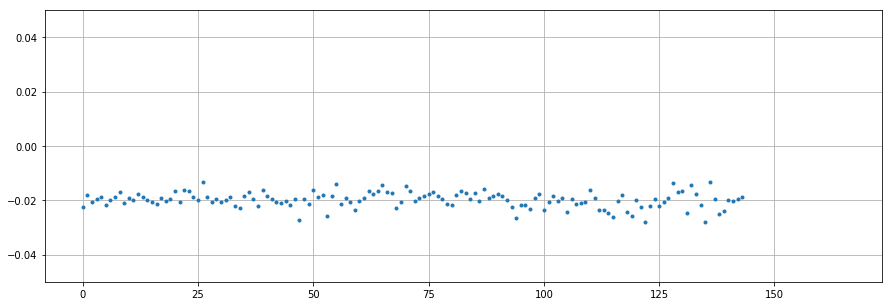

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(agg_regrouped['color_term'], '.')
plt.ylim(-0.05, 0.05)
plt.grid()

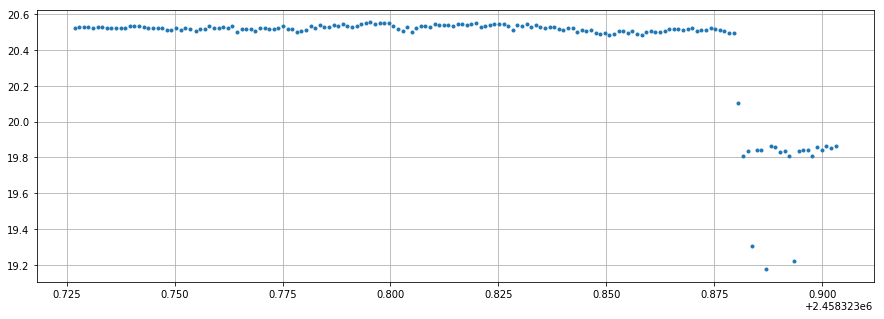

In [19]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(agg_regrouped['t_mid_tdb'], agg_regrouped['zero_point'], '.')
#plt.ylim(20, 21)

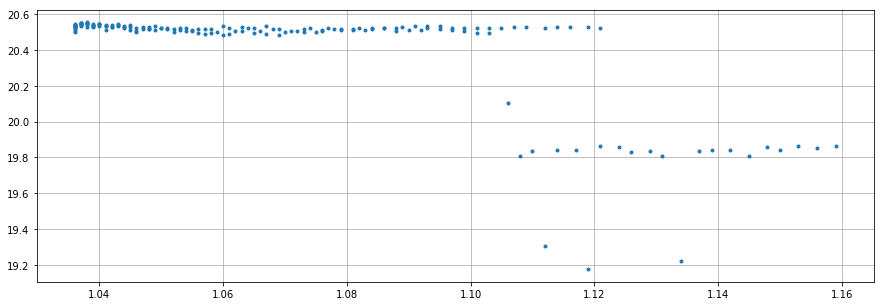

In [20]:
plt.figure(figsize=(15, 5))

plt.plot(agg_regrouped['airmass'], agg_regrouped['zero_point'], '.')
#plt.ylim(20, 21)
plt.grid()


In [22]:
gain = 1.47
read_noise = 9.42
dark_current = 0.01

In [23]:
mags = Table.read('calibrated_magnitudes_kelt_16_faint_13.fits')

In [24]:
snr = (gain * mags['aperture_net_flux'] / 
       np.sqrt(gain * mags['aperture_net_flux'] + 
               mags['aperture_area'] * (1 + mags['aperture_area']/mags['annulus_area']) *
               (gain * mags['sky_per_pix_avg'] + 
                gain * dark_current * mags['exposure'] +
                read_noise**2
               )
              ))

In [25]:
snr.max()

1612.506328384899

In [27]:
mag_error = 1 / snr
mag_error

0.03554203721814884
0.010865317328612463
0.21162200178674756
0.028532498737706097
0.013127131925856725
0.09620434270592455
0.08801476817405915
0.06594961678474937
0.09575037644968758
0.005352178717360018
0.03523151162172711


In [28]:
mags['mag_error'] = mag_error

In [29]:
mags.write('calibrated_magnitudes_kelt_16_faint_13.fits', overwrite=True)

In [30]:
mags

id,xcenter,ycenter,aperture_sum,annulus_sum,RA,Dec,sky_per_pix_avg,sky_per_pix_med,sky_per_pix_std,aperture,aperture_area,annulus_inner,annulus_outer,annulus_area,exposure,date-obs,night,aperture_net_flux,mag_inst_r,airmass,filter,file,star_id,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb,vsx_name,mag_error
,pix,pix,adu,,deg,deg,adu,adu,adu,pix,,pix,pix,,s,,,adu,,,,,,,,,,,,adu
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,int32,float64,float64,float64,bytes1,bytes28,int32,float64,float64,float64,float64,float64,bytes50,float64
1422,4011.091526838012,3969.142916177813,19740.155430793762,103860.89329612255,314.5432670134417,32.01973136240193,31.808280954476942,31.461752891540527,10.803624996914255,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,5350.428135927457,-5.293886548969706,1.121,r,kelt-16-S001-R001-C001-r.fit,1479,15.214845041740617,20.524021782107393,-0.022386809287167866,2458323.726455484,2458323.7268027063,,0.03554203721814884
1431,3863.942898239571,3998.9143066290862,33952.74383163452,102687.83718004823,314.51558576760186,32.01961637265539,31.504446114354263,31.2497501373291,10.520896497204099,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,19700.46818020352,-6.709106579064407,1.121,r,kelt-16-S001-R001-C001-r.fit,1489,13.799244435989024,20.524021782107393,-0.022386809287167866,2458323.7264559236,2458323.726803146,,0.010865317328612463
1411,3963.0904975394483,3951.90486856516,15249.548798561096,104428.82190561295,314.5352479090502,32.015567615887285,31.808294335373855,31.52717399597168,10.731908677068274,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,859.8154503196401,-3.3089283230064974,1.121,r,kelt-16-S001-R001-C001-r.fit,1468,nan,20.524021782107393,-0.022386809287167866,2458323.7264559385,2458323.7268031607,,0.21162200178674756
1421,3923.008965618607,3969.8875728993826,20822.206637382507,101420.80074810982,314.52733781030184,32.017048316638714,31.151097199642955,30.903825759887695,10.454439681919503,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,6729.782269015484,-5.542917744838749,1.121,r,kelt-16-S001-R001-C001-r.fit,1478,14.962746853484397,20.524021782107393,-0.022386809287167866,2458323.726455944,2458323.7268031663,,0.028532498737706097
1405,4015.1792324262733,3923.173770284605,30234.403473317623,104178.87234064937,314.54572817533784,32.01282162890551,31.792475467154404,31.450231552124023,10.459912367244256,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,15851.826412462999,-6.473113480632851,1.121,r,kelt-16-S001-R001-C001-r.fit,1461,14.035685270542295,20.524021782107393,-0.022386809287167866,2458323.726455993,2458323.726803215,,0.013127131925856725
1417,3848.017315598605,3961.9101672544393,16185.751720428467,115460.04435215145,314.5140998526454,32.013443881563674,31.558219960992364,30.922298431396484,10.712969735233127,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,1909.1493538937557,-4.175014973009543,1.121,r,kelt-16-S001-R001-C001-r.fit,1474,nan,20.524021782107393,-0.022386809287167866,2458323.7264564354,2458323.7268036576,,0.09620434270592455
1419,3723.004118947109,3968.894287448843,16342.364827394485,102438.52531147748,314.49127182053485,32.01053792907989,31.50461414878146,31.270769119262695,10.508239826067275,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,58322,2090.013158979509,-4.273287762138963,1.121,r,kelt-16-S001-R001-C001-r.fit,1476,nan,20.524021782107393,-0.022386809287167866,2458323.7264570193,2458323.7268042415,,0.08801476817405915
1438,3604.9472263665893,4021.055869255223,16588.801261663437,99055.38167959452,314.4680014835236,32.014766868890604,30.492322640378536,30.28482151031494,9.544357245216066,12.0,452.3893421169302,27.0,42.0,3251.548396465436,60.0,2018-07-24T05:19:53,

Text(0.5,0,'t_mid_tdb')

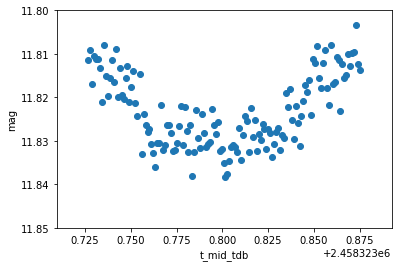

In [52]:
this_star = mags['star_id'] == 802
plt.scatter(mags['t_mid_tdb'][this_star][0:140], mags['mag_cal'][this_star][0:140])
plt.ylim(11.8, 11.85)
plt.ylim(reversed(plt.ylim()))
plt.ylabel('mag')
plt.xlabel('t_mid_tdb')